In [6]:
import matplotlib.pyplot as plt
import numpy as np
import constants
import const
from types import SimpleNamespace
from sympy import symbols, diff, sqrt, exp

In [7]:
### calculate constants based on Equation E1 and parameters in Table E1
# frequency dependent photoionization HI cross sections (given in cm^2 as a function of photon energy ε)
# we only have 1 photon species with energy 13.6eV
x = constants.e_HI/(constants.ε0*1.602e-12) - constants.y0
y = np.sqrt(x**2+constants.y1**2)
sigma_ε = constants.sigma0*((x-1)**2+constants.yw**2)*(y**(0.5*constants.P-5.5))/(1+np.sqrt(y/constants.ya))**constants.P # if ε > ε_ion
# and 0 cm^2 otherwise
sigma_ε

6.346296358990505e-18

## Initial conditions from radiation + fluid step

In [18]:
# from Zack's code:
import const
from helper import *

import numpy as np
import matplotlib.pyplot as plt
from sim import Init, Grid

def gaussian(x, mu, sigma):
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))

In [4]:
grid = Grid(N=256, C=0.4, bc_typ=PER, rsolve=HLL, sloper=MONCEN)

with Init(grid) as grid:
    # initialize primitive variables
    grid.w[RHO] = 1
    grid.w[VX]  = -0.5 * (np.abs(grid.y-0.5)<0.25) + 0.5*(np.abs(grid.y-0.5)>0.25)
    grid.w[VY]  = 0.1 * np.sin(4*np.pi*grid.x) * (gaussian(grid.y, 0.25, 0.05) + gaussian(grid.y, 0.75, 0.05))
    grid.w[P]   = 2.5

for i in range(2):
    # inject photons
    for j in np.arange(0.45, 0.555, 0.005): grid.inject([0.05, j], 100, xflux=0.99, yflux=0)
    for k in np.arange(0.45, 0.555, 0.005): grid.inject([0.95, k], 100, xflux=-0.99, yflux=0)
    
    grid.step()

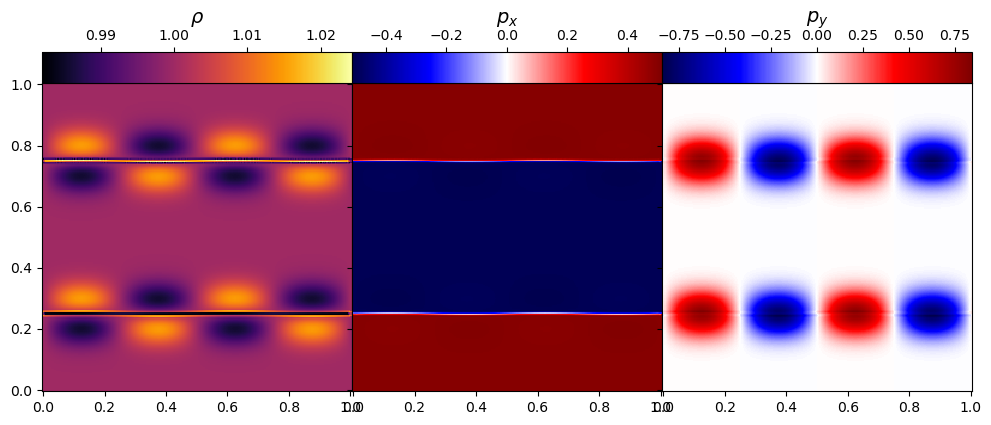

In [5]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
plt.subplots_adjust(hspace=1e-3, wspace=1e-3)

for i in range(3):
    
    cmap  = ['inferno', 'seismic', 'seismic'][i]
    label = [r'$\rho$', r'$p_x$', r'$p_y$'][i]
    
    im   = axs[i].pcolormesh(grid.x, grid.y, grid.u[i], cmap=cmap)
    cax  = axs[i].inset_axes([0, 1, 1, 0.1])
    cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
    
    cbar.set_label(label, fontsize=14)
    cax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    cax.xaxis.set_label_position('top')


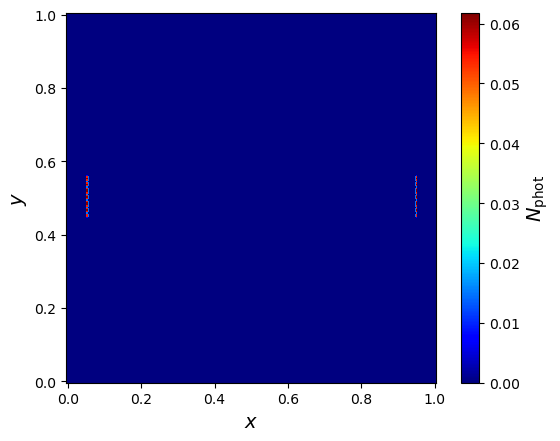

In [6]:
plt.pcolormesh(grid.x, grid.y, grid.urad[NPHOT], cmap='jet')
plt.gca().set_aspect(True)
cbar = plt.colorbar()

plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$y$', fontsize=14)
cbar.set_label(r'$N_{\rm phot}$', fontsize=14)


## Extract the variables for now to test

In [9]:
def U2UT(U):
    """
    Convert conserved variable U to conserved variable UT in thermochemostry step
    """
    # Conserved Variables
    [rho, momx, momy, E, rho_xHII, N, Fx, Fy] = U
    # thermochemical state
    vx = momx / rho
    vy = momy / rho
    vsq = vx**2 + vy**2

    ε = E - 0.5 * rho * vsq
    rho_HII = rho_xHII
    n_HII = rho_HII / constants.mH
    n_HI = (rho - rho_HII) / constants.mH
#     print(n_HI, n_HII)
    x_HII = n_HII / (n_HI + n_HII)

    UT = [ε, x_HII, N, Fx, Fy]
    return UT

The cell-thermochemistry is called once every RT time-step of length $∆t_{RT}$ , but in each cell it is split into local sub-steps of length $∆t$ that adhere to the 10\% rule,

$$
\rm max \left(\left|\frac{\Delta \mathcal{U}_T}{ \mathcal{U}_T}\right|\right) \leq 0.1
$$

The RT step thus contains a loop for each cell, which calls the thermo\_step(UT,$∆t$) routine once or more often: first with $∆t = ∆t_{RT}$ , then possibly again a number of times to fill in $∆t_{RT}$ if the first guess at ∆t proves too long to meet the condition

## Update photon density N and flux F

In [10]:
def N_F_update(U, dt):
    """
    Update photon density N and flux F.
    We first update the photon density N because the photon densities appear to be the most dynamic variables 
    and so are also most likely to break the time-step condition
    --------------------
    Input:
    U: conserved variable from the current time step to the starting time step
    dt: time-step of the sub-step
    --------------------
    Output:   
    N_new, F_new_x, F_new_y
    
    """
    [rho, momx, momy, E, rho_xHII, N, Fx, Fy] = U
    rho_HII = rho_xHII
    n_HII = rho_HII / constants.mH
    n_HI = (rho - rho_HII) / constants.mH
    # get UT from U
    UT = U2UT(U)
    # photon-creating recombination term C is non-existent since OTSA is assumed
    ε, x_HII, N, Fx, Fy = UT # get the conserved variable at the current time-step
    # update N
    D = constants.cr * constants.sigma_HI_N * n_HI # photon destruction factor
    N_new = N / (1+dt*D)
    # update F
    F_new_x = Fx / (1+dt*D)
    F_new_y = Fy / (1+dt*D)

    return N_new, F_new_x, F_new_y

## Update temperature (thermal)

First, we write down the cooling function $\mathcal{L}$ and algebraically differentiate it with respect to temperature $T$.

\begin{align}
    \mathcal{L} & = [\zeta_{\rm HI}(T) + \Phi_{\rm HI}(T)]n_e n_{\rm HI} \\
                & + \eta_{\rm HII}^B(T)n_e n_{\rm HI} \\
                & + \theta(T)n_e n_{\rm HII} \\
                & + \omega(T)n_e
\end{align}

We also algebraically differentiate the case B recombination coefficient $\alpha_{\rm HII}^B$ with respect to $T$

$$
\alpha_{\rm HII}^B = 2.753 \cdot 10^{-14} \frac{\lambda_{\rm HI}^{1.5}}{[1+(\lambda_{\rm HI}/2.74)^{0.407}]^{2.242}} 
$$

In [11]:
def E_update(U, dt):
    """
    Update energy E and temperature T
    --------------------
    Input:
    U: conserved variable from the current time step to the starting time step
    dt: time-step of the sub-step
    --------------------
    Output: 
    Tmu_new
    
    """
    [rho, momx, momy, E, rho_xHII, N, Fx, Fy] = U
    rho_HII = rho_xHII
    UT = U2UT(U)
    [ε, x_HII, N, Fx, Fy] = UT
    n_HII = rho_HII / constants.mH
    n_HI = (rho - rho_HII) / constants.mH
    # calculate temperature using equation A4
    T = ε * ((constants.gamma-1)*constants.mH) / (rho * constants.kB) * constants.mu
    ## coefficients in the cooling function (copied from coolrates_module.f90 in RAMSES-RT)
    # cooling rate coefficients
    T5 = T/1.e5
    f = 1.+np.sqrt(T5)
    hf = 0.5/f
    zeta_HI  = 1.27e-21 * np.sqrt(T) / f * np.exp(-157809.1/T)
    dζ_dlogT = (hf + 157809.1/T) * np.log(10) * zeta_HI
    zeta_HI_prime = dζ_dlogT / (T * np.log(10))
    # collisional excitation cooling rate coefficients
    phi_HI  = 7.5e-19 / f * np.exp(-118348./T)
    dψ_dlogT = (-118348/T - 0.5 * np.sqrt(T5) / f) * np.log(10) * phi_HI
    phi_HI_prime = dψ_dlogT / (T * np.log(10))
    # Bremsstrahlung cooling rate coefficients
    theta_HII = 1.42e-27 * np.sqrt(T)
    dθ_dlogT = 0.5 * theta_HII * np.log(10)
    theta_HII_prime = dθ_dlogT / (T * np.log(10))
    # Compton cooling/heating rate coefficient    
    Ta     = 2.727/constants.aexp
    pomega   = 1.017e-37 * Ta**4 * (T-Ta)
    dpomega_dlogT = (T / (T - Ta)) * np.log(10) * pomega
    pomega_prime = dpomega_dlogT / (T * np.log(10))
    # case B recombination cooling rate coefficient
    laHII    = 315614./T
    f = 1.+(laHII/2.25)**0.376
    eta_HII_B    = 3.435e-30 * laHII**1.97 / f**3.72 * T
    dη_dlogT = (-0.97 + 1.39827*(f - 1.)/f ) * np.log(10) * eta_HII_B
    eta_HII_B_prime = dη_dlogT / (T * np.log(10))
    
    ## the heating function
    H = n_HI * constants.cr * N * (constants.e_photon * constants.sigma_HI_E - constants.e_HI * constants.sigma_HI_N)
    # electron number density should be the same as HII number density in our case
    n_e = n_HII
    ## the cooling function
    L = (zeta_HI + phi_HI) * n_e * n_HI + \
        eta_HII_B * n_e * n_HII + \
        theta_HII * n_e * n_HII + \
        pomega * n_e
    Lambda = H + L
    K = (constants.gamma - 1) * constants.mH / (rho * constants.kB)    
    # Attention!! This mu is different from the mu in the constants.py
    # here X is the hydrogen mass fraction, which is 1 in our case
    mu = 1 / (constants.X * (1+x_HII))
    
    # dLdT is algebraically differentiated based on analytical functions of the cooling rate L shown above  
    dLdT = (zeta_HI_prime + phi_HI_prime) * n_e * n_HI + \
        eta_HII_B_prime * n_e * n_HII + \
        theta_HII_prime * n_e * n_HII + \
        pomega_prime * n_e
    dLambdadt = mu * dLdT

    ## Update temperature
    Tmu = T / mu
    Tmu_new = Tmu + (Lambda * K * dt)/ (1 - dLambdadt * K * dt)
    
    return Tmu_new

## Update hydrogen ionization fraction

In [12]:
def x_HII_update(U, dt):
    """
    Update energy hydrogen ionized fraction x_HII
    --------------------
    Input:
    U: conserved variable from the current time step to the starting time step
    dt: time-step of the sub-step
    --------------------
    Output: 
    x_HII_new
    
    """
    [rho, momx, momy, E, rho_xHII, N, Fx, Fy] = U
    rho_HII = rho_xHII
    UT = U2UT(U)
    [ε, x_HII, N, Fx, Fy] = UT
    n_HII = rho_HII / constants.mH
    n_HI = (rho - rho_HII) / constants.mH
    n_e = n_HII
    # calculate temperature using equation A4
    T = ε * ((constants.gamma-1)*constants.mH) / (rho * constants.kB) * constants.mu
    
    mu = 1 / (constants.X * (1+x_HII))
    Tmu = T/mu
    # photon destruction factor, the creation term is 0
    D = constants.cr * constants.sigma_HI_N * n_HI
    # recombination rate coefficients
    lambda_HI = 315614 / T
    f = 1.+(lambda_HI/2.74)**0.407
    alpha_HII_B = 2.753e-14 * lambda_HI**1.5 / f**2.242
    # algebraically differentiate alpha_HII_B in terms of T as shown above
    # copied from coolrates_module.f90 in RAMSES-RT
    dα_dlogT = ( 0.912494 * ((f - 1.)/f) - 1.5 ) * np.log(10) * alpha_HII_B
    dalpha_HIIBdT = dα_dlogT / ( T * np.log(10) )
    n_H = n_HI + n_HII
    dDdx_HII = n_H * alpha_HII_B - n_e * Tmu * mu**2 * X * dalpha_HIIBdT
    J = -D - x_HII * dDdx_HII
    
    ## update x_HII
    x_HII_new = x_HII + dt * (-x_HII * D) / (1-J*dt)

    return x_HII_new

## The entire thermo step

In [11]:
def thermo_step(U, dt):
    # first, expand U
    [rho, momx, momy, E, rho_xHII, N, Fx, Fy] = U
    rho_HII = rho_xHII
    x_HII = rho_HII / rho
    vx = momx / rho
    vy = momy / rho
    # convert to UT
    UT = U2UT(U)
    # UT is what we are evolving in the thermochemistry step
    [ε, x_HII, N, Fx, Fy] = UT
    
    ########## 1. update N and F
    N_new, Fx_new, Fy_new = N_F_update(U, dt)
    # update the last three terms of UT and U
    UT_new = [ε, x_HII, N_new, Fx_new, Fy_new]
    U_new = [rho, momx, momy, E, rho_HII, N_new, Fx_new, Fy_new]
    
    ########## 2. update T with the new U
    Tmu_new = E_update(U_new, dt)
    # convert Tmu_new to a ε_new
    ε_new = Tmu_new / ((constants.gamma-1)*constants.mH / (rho * constants.kB))
    # update UT
    UT_new2 = [ε_new, x_HII, N_new, Fx_new, Fy_new]
    # update E
    vsq = vx**2 + vy**2
    E_new = ε_new + 0.5 * rho * vsq   
    # now we can update U again with the new energy
    U_new2 = [rho, momx, momy, E_new, rho_HII, N_new, Fx_new, Fy_new]
    
    ########## 3. update x_HII
    x_HII_new = x_HII_update(U_new2, dt)
    rho_HII_new = rho / x_HII_new
    ########## update UT
    UT_new3 = [ε_new, x_HII_new, N_new, Fx_new, Fy_new]
    ########## update U
    U_new = [rho, momx, momy, E_new, rho_HII_new, N_new, Fx_new, Fy_new]
    
    return UT_new3, U_new

### Set up physical units

In [32]:
Nside     = 256
nH_init   = 1e2
vx_init   = 0
vy_init   = 0
temp_init = 100
boxsize   = 10*const.pc
Ndot      = 2e48
c_red     = 6e-4*const.c
time_sim  = 100*const.kyr
x_init    = 0

rho_init  = nH_init*constants.mH
p_init    = nH_init*constants.kB*temp_init


In [33]:
unit = SimpleNamespace(
    length = boxsize,
    time   = const.kyr,
    mass   = const.Msol,
    phot   = 1e58
)
unit.density = unit.mass/unit.length**3
unit.vel = unit.length/unit.time
unit.energy_density = unit.density*unit.vel**2


In [43]:
grid = Grid(N=Nside, C=0.4, bc_typ=[NEU, NEU], rsolve=HLL, sloper=MONCEN)

with Init(grid) as grid:
    
    grid.w[RHO] = rho_init/unit.density
    grid.w[VX]  = vx_init/unit.vel
    grid.w[VY]  = vy_init/unit.vel
    grid.w[P]   = p_init/unit.energy_density
    grid.u[ION] = x_init*rho_init/unit.density


In [67]:
#while grid.t < time_sim/unit.time:
for i in range(100):
    
    grid.inject([0.5, 0.5], Ndot/unit.phot)
    grid.step()


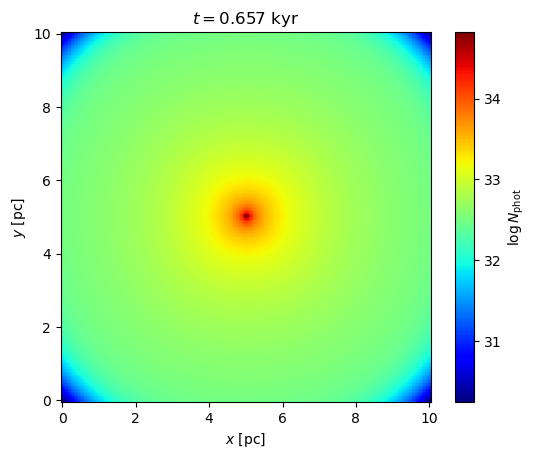

In [68]:
plt.pcolormesh(grid.x*unit.length/const.pc, grid.y*unit.length/const.pc, np.log10(grid.urad[NPHOT]*unit.phot), cmap='jet')
plt.gca().set_aspect(True)
cbar = plt.colorbar()

plt.title(r'$t = %.3g~{\rm kyr}$' % (grid.t * unit.time))
plt.xlabel(r'$x$ [${\rm pc}$]')
plt.ylabel(r'$y$ [${\rm pc}$]')
cbar.set_label(r'$\log N_{\rm phot}$')


### Set up the simulation

In [14]:
for i in range(200):
    # inject photons
    for j in np.arange(0.45, 0.555, 0.005): grid.inject([0.05, j], Ninject, xflux=0.99*Ninject, yflux=0)
    for k in np.arange(0.45, 0.555, 0.005): grid.inject([0.95, k], Ninject, xflux=-0.99*Ninject, yflux=0)
    ### fluid + radiation 
    grid.step()
    # retrieve conserved variables
    vx = grid.w[VX]
    vy = grid.w[VY]
    pressure = grid.w[P]
    rho = grid.u[RHO]
    momx = grid.u[PX]
    momy = grid.u[PY]
    energy = grid.u[E]
    rho_HII = grid.u[ION]
    #print(rho_HII)
    # convert U from code units to physical units
    vx_phys = vx * v_init
    vy_phys = vy * v_init
    rho_phys = rho * rho_init # g/cm^3, factor is derived from initial condition nH = 10^2 cm^3 so rho = mH/nH
    momx_phys = rho_phys * vx_phys 
    momy_phys = rho_phys * vy_phys 
    energy_phys = pressure * P_init / (constants.gamma - 1) + rho_phys/2*(vx_phys**2+vy_phys**2)
    rho_HII_phys = rho_HII * rho_init
    # convert time step from code units to physical units
    dt = grid.dt
    dt_phys = dt * time_init
    print("dt", dt_phys)
    # convert N, F from code units to physical units
    N = grid.urad[NPHOT]
    Fx = grid.urad[XFLUX]
    Fy = grid.urad[YFLUX]
    N_phys = N
    Fx_phys = Fx * deltax**2 * dt_phys
    Fy_phys = Fx * deltax**2 * dt_phys
    ### stack the variables together to feed into thermo step
    U = np.zeros((8,258,258))
    U[:] = np.array([rho_phys, momx_phys, momy_phys, energy_phys, rho_HII_phys, N_phys, Fx_phys, Fy_phys])
    UT_new, U_new = thermo_step(U, dt_phys)
    # convert new U and new UT back to code units
    [rho_new, momx_new, momy_new, energy_new, rho_HII_new, N_new, Fx_new, Fy_new] = U_new
    rho_new_code = rho_new / rho_init
    vx_new = momx_new / rho_new
    vy_new = momy_new / rho_new
    vx_new_code = momx_new / rho_new / v_init
    vy_new_code = momy_new / rho_new / v_init
    momx_new_code = rho_new_code * vx_new_code
    momy_new_code = rho_new_code * vy_new_code
    P_new = (constants.gamma-1)*(energy_new-rho_new/2*(vx_new**2+vy_new**2))
    energy_new_code = P_new / P_init / (constants.gamma - 1) + rho_new_code/2*(vx_new_code**2+vy_new_code**2)
    rho_HII_new_code = rho_HII_new / rho_init
    N_new_code = N_new
    Fx_new_code = Fx_new / deltax**2 / dt_phys
    Fy_new_code = Fy_new / deltax**2 / dt_phys
    # update U to be fed into the next interation of fluid + radiation step
    grid.u[RHO] = rho_new_code
    grid.u[PX] = momx_new_code
    grid.u[PY] = momy_new_code
    grid.u[E] = energy_new_code
    grid.u[ION] = rho_HII_new_code
    grid.urad[NPHOT] = N_new_code
    grid.urad[XFLUX] = Fx_new_code
    grid.urad[YFLUX] = Fy_new_code
    
#     print(rho_new_code)

dt 12069860.70756411
dt 11982153.985554554
dt nan
dt nan
dt nan
dt nan


/var/folders/j1/x1_ywbh94cx2d4ht4qc5s1yw0000gp/T/ipykernel_48773/1878854796.py:33: RuntimeWarning: divide by zero encountered in divide
  rho_HII_new = rho / x_HII_new
/Users/yp9846/Class/APC523 Numerical Algorithms/hydro-M1/sim.py:256: RuntimeWarning: invalid value encountered in subtract
  dw_L[sl.x+sl.ij] = (self.w[sl.ij]   - self.w[sl.im1j]) / self.dx
/Users/yp9846/Class/APC523 Numerical Algorithms/hydro-M1/sim.py:257: RuntimeWarning: invalid value encountered in subtract
  dw_L[sl.y+sl.ij] = (self.w[sl.ij]   - self.w[sl.ijm1]) / self.dx
/Users/yp9846/Class/APC523 Numerical Algorithms/hydro-M1/sim.py:258: RuntimeWarning: invalid value encountered in subtract
  dw_C[sl.x+sl.ij] = (self.w[sl.ip1j] - self.w[sl.im1j]) / (2*self.dx)
/Users/yp9846/Class/APC523 Numerical Algorithms/hydro-M1/sim.py:259: RuntimeWarning: invalid value encountered in subtract
  dw_C[sl.y+sl.ij] = (self.w[sl.ijp1] - self.w[sl.ijm1]) / (2*self.dx)
/Users/yp9846/Class/APC523 Numerical Algorithms/hydro-M1/sim.py:

dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan
dt nan

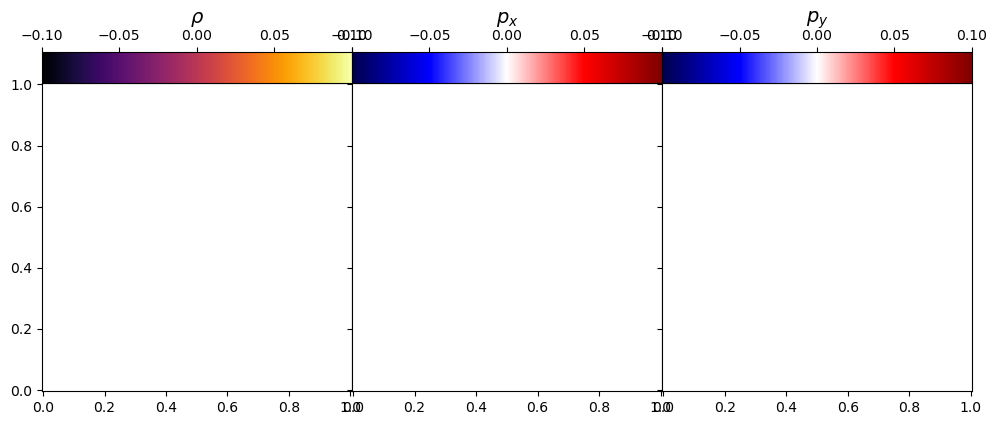

In [15]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
plt.subplots_adjust(hspace=1e-3, wspace=1e-3)

for i in range(3):
    
    cmap  = ['inferno', 'seismic', 'seismic'][i]
    label = [r'$\rho$', r'$p_x$', r'$p_y$'][i]
    
    im   = axs[i].pcolormesh(grid.x, grid.y, grid.u[i], cmap=cmap)
    cax  = axs[i].inset_axes([0, 1, 1, 0.1])
    cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
    
    cbar.set_label(label, fontsize=14)
    cax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    cax.xaxis.set_label_position('top')
